In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


## Optimization in many dimensions


Our test landscape is a sum of Gaussian wells,
$$
\mathcal{L} = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

The gradient of this landscape is
$$
\nabla \mathcal{L} = \sum_{p=1}^P \frac{(\mathbf{x} - \boldsymbol{\mu}_{p})}{\sigma^2} \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$

A few considerations:
+ Having a smooth landscape is important for optimization algorithms to work well. 
+ Optimization landscapes that are differentiable are necessary in order to compute gradient updates, and flat regions in the landscape pose challenges.

(-3.3, 3.3, -3.3, 3.3)

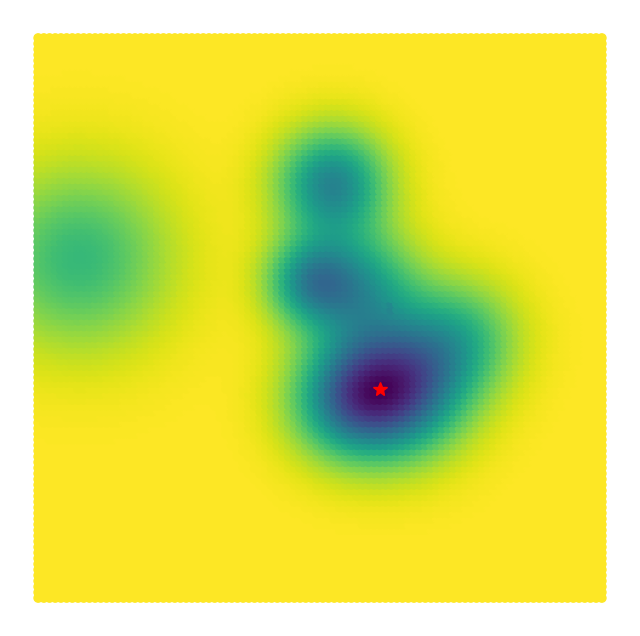

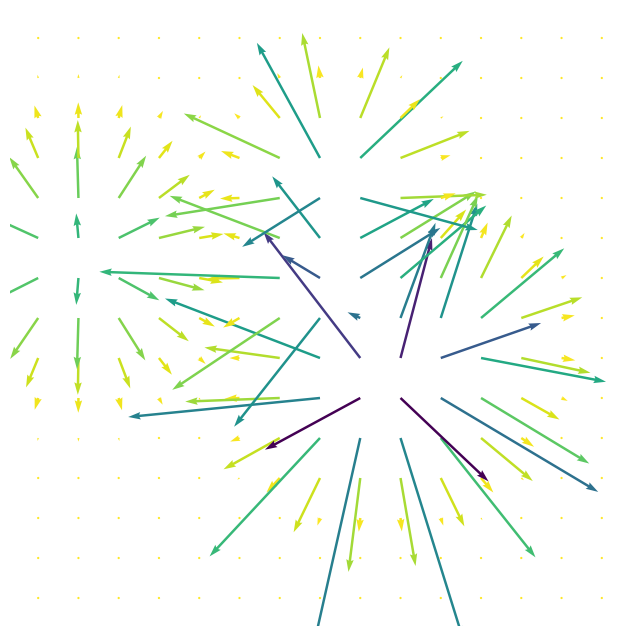

In [2]:

class RandomLossLandscape:
    """Creates a random two-dimensional loss landscape with multiple circular gaussian wells"""

    def __init__(self, d=2, n_wells=3, random_state=None):
        
        self.random_state = random_state
        np.random.seed(random_state)
        self.coeffs = np.random.random(n_wells)
        self.coeffs /= np.sum(self.coeffs)
        self.locs = np.random.randn(n_wells, d)
        self.widths = np.random.rand(n_wells)[None, :]

    def _gaussian_well(self, X, width=1):
        return -np.exp(-np.sum((X / width) ** 2, axis=1))

    def _grad_gaussian_well(self, X, width=1):
        return -2 * X / (width ** 2) * self._gaussian_well(X, width)[:, None, :]

    def loss(self, X):
        # X shape before summation is (n_batch, n_dim)
        # Arg shape before summation is (n_batch, n_wells)
        # print(self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths).shape)
        return np.einsum('...i,i->...', self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), self.coeffs)

    def grad(self, X):
        # Arg shape before summation is (n_batch, n_dim, n_wells)
        return np.einsum('...i,i->...', self._grad_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), self.coeffs)

    def __call__(self, X):
        return self.loss(X)


loss = RandomLossLandscape(random_state=0, n_wells=8)
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss(X) # same as loss.loss(X) because class is callable

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*r', markersize=10)
plt.axis('off')

plt.figure(figsize=(8, 8))
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)
plt.quiver(X[:, 0], X[:, 1], loss.grad(X)[:, 0], loss.grad(X)[:, 1], Z, scale=1e0)
# plt.streamplot(x, y, loss.grad(X)[:, 0].reshape(100, 100), loss.grad(X)[:, 1].reshape(100, 100), color=Z.reshape(100, 100))
plt.axis('off')

## Computing analytic gradients is hard

+ Computing analytic gradients is hard, and often impossible.
+ We can use finite differences to approximate the gradient, but this is computationally expensive: In $d$ dimensions, we need to evaluate the function $d$ times to compute the gradient. Impractical for high-dimensional problems.
+ Symbolic gradients are useful, but prone to errors
+ We use a gradcheck function to mitigate the risk of errors in our gradients.
+ (Later in the course): Faster gradient estimation for more complex loss functions with automatic differentiation (the symbolic chain rule for arbitrary compositions of primitive functions).


In [3]:
def gradcheck(loss, x, eps=1e-9):
    """Checks the gradient of a function at a point"""
    x = np.array(x)
    grad = loss.grad(x)
    grad_num = np.zeros_like(grad)
    for i in range(x.size):
        x1 = x.copy()
        x2 = x.copy()
        x1.flat[i] += eps
        x2.flat[i] -= eps
        grad_num.flat[i] = (loss(x1) - loss(x2)) / (2 * eps)
    return grad, grad_num

grad, grad_num = gradcheck(loss, np.random.randn(2))

print(f"True gradient: {grad}, Approximate gradient: {grad_num}")

True gradient: [[-0.00074594 -0.00069947]], Approximate gradient: [[-0.00074594 -0.00069947]]


# Global maximization

+ Why bother using gradient descent when we can just check every point in our system's domain? That's literally how we generated the plot above.
+ For a continuous field, we need to pick some minimum length scale over which we don't expect the objective to change rapidly. For discrete optimization, we just try all combinations
+ Assume we need $N$ points to sample along any linear dimension. The number of queries to the objective function scales as $N^d$, where $d$ is the dimensionality



+ For the example we just used, we sampled $N = 100$ points along each dimension, resulting in $100^2 = 10^4$ function calls. 
+ Assuming $100$ points per axis, when $d = 3$ we have $10^6$ while for $d = 7$ it takes $10^14$, etc
+ Let's assume it takes $10$ $\mu s$ per evaluation. The 2D global search takes $0.1$ s, the 3D search takes $10$ s, the $d = 5$ search takes $1.15$ days, and the $d = 7$ search takes $32$ years

+ OpenAI DallE: an image generation model with $d = 12$ billion parameters. During training, this parameter space is searched in order to minimize a loss objective 
+ Local methods are probably a better idea

## Multivariate gradient descent

+ A first-order optimization method
+ If we assume that our current position is $\mathbf{x}$, then the gradient of the objective function at this point is $\nabla \mathcal{L}(\mathbf{x})$
+ The gradient descent update rule becomes $$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x})$$ where $\eta$ is a step size parameter we call the "learning rate" that determines the size of the step we take in the direction of the gradient

In [4]:
class BaseOptimizer:
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, lr=0.1, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
        self.loss = loss
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        
        self.X = X
        if self.store_history:
            self.Xs = [self.X.copy()]
            self.losses = [self.loss(X)]
        for i in range(self.max_iter):
            
            self.X = self.update(self.X)
            #self.X -= self.lr * self.loss.grad(self.X)

            if self.store_history:
                self.Xs.append(self.X.copy())
                self.losses.append(self.loss(self.X))

            # Stop early if loss is not decreasing any more for *any* batch elements
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break

        return self
    
    def update(self, X):
        raise NotImplementedError("Implement this method in a subclass")


class GradientDescent(BaseOptimizer):
    """A Multivariate Gradient Descent Optimizer"""

    def update(self, X):
        return X - self.lr * self.loss.grad(X)

# class MultivariateGradientDescent:
#     """A Multivariate Gradient Descent Optimizer"""

#     def __init__(self, loss, lr=0.1, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
#         self.loss = loss
#         self.lr = lr
#         self.max_iter = max_iter
#         self.tol = tol
#         self.random_state = random_state
#         np.random.seed(random_state)
#         self.store_history = store_history
#         if self.store_history:
#             self.Xs = []
#             self.losses = []

#     def fit(self, X):
        
#         self.X = X
#         if self.store_history:
#             self.Xs = [self.X.copy()]
#             self.losses = [self.loss(X)]
#         for i in range(self.max_iter):

#             self.X -= self.lr * self.loss.grad(self.X)

#             if self.store_history:
#                 self.Xs.append(self.X.copy())
#                 self.losses.append(self.loss(self.X))

#             # Stop early if loss is not decreasing any more for *any* batch elements
#             if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
#                 break


In [8]:
# Initialize optimizer
optimizer = GradientDescent(loss, lr=0.1, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

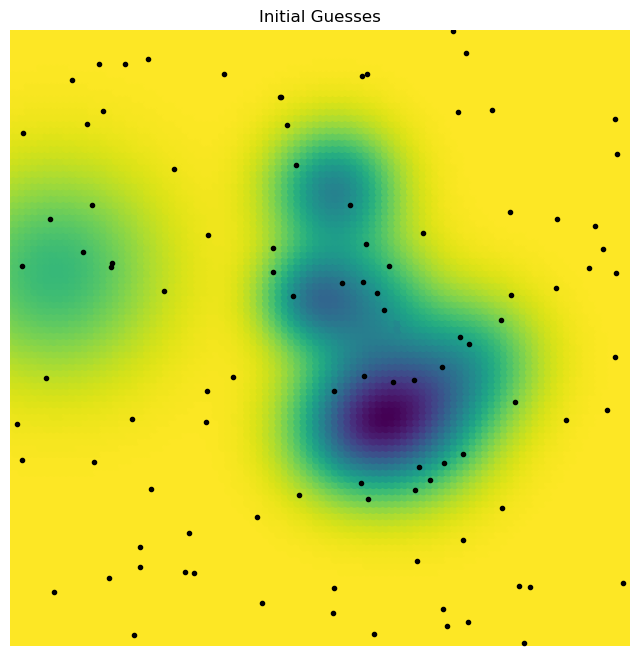

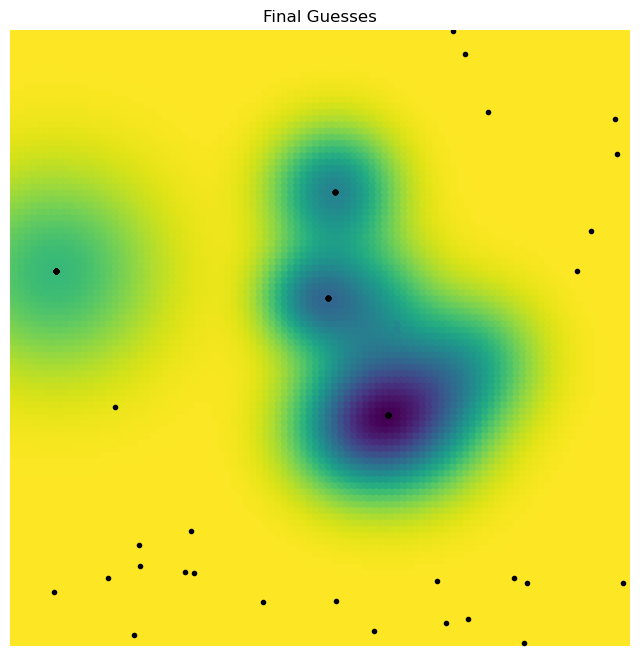

In [9]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*optimizer.X.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

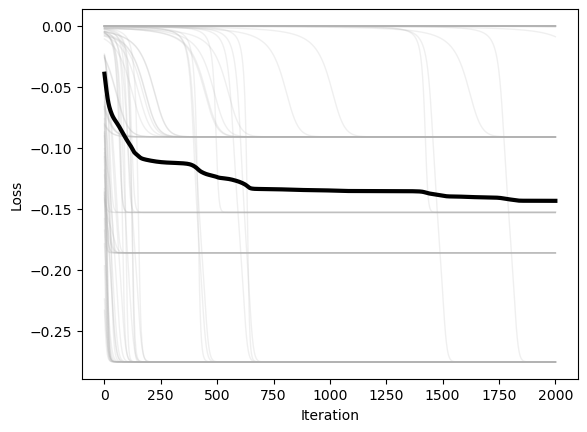

In [10]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


Text(0.5, 1.0, 'Final Guesses')

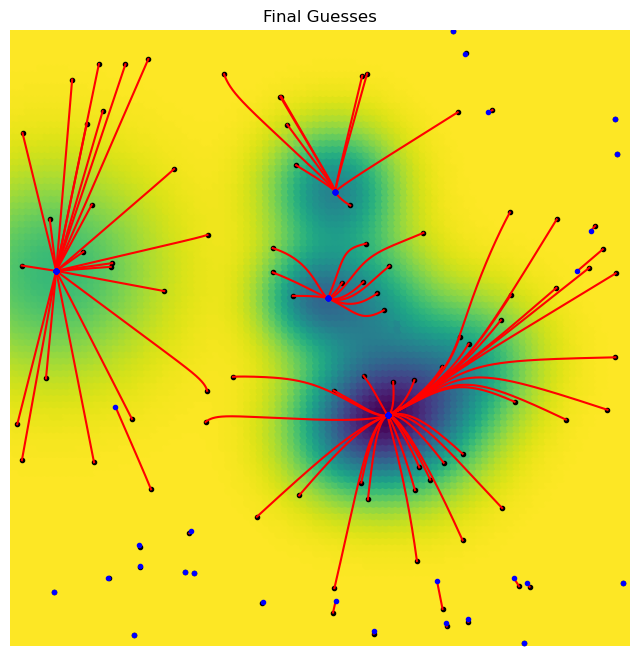

In [11]:
Xs = np.array(optimizer.Xs)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b');
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [12]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.b');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

## Hyperparameter tuning: What is the correct learning rate? Momentum?

+ Hyperparameter tuning is a big deal in machine learning, we will revisit this topic later in the course
+ For now, we will use intution to see how the learning rate and other hyperparameters affect the dynamics of the system

## Momentum and stochasticity

We can think of gradent descent as the dynamics of a first-order overdamped system:

For a particle of mass $m$ in a potential $V(\mathbf{x})$, the forces acting on the particle are given by Newton's second law:
$$
\mathbf{F} = -\nabla \mathcal{U}(\mathbf{x})
$$

$$
\mathbf{a} = \frac{\mathbf{F}}{m}
$$

If we assume linear damping with a damping coefficient $\gamma$, then the dynamics of the particle are given by the kinematic equation:

$$
m \ddot{\mathbf{x}} = -\gamma \dot{\mathbf{x}} - \nabla \mathcal{U}(\mathbf{x})
$$
where $\mathbf{F}$ is the force, $\mathbf{a}$ is the acceleration.

If we assume $\gamma \gg m$, then the overdamped dynamics are given by the first-order equation of motion:
$$
\dot{\mathbf{x}} = -\frac{1}{\gamma}\nabla \mathcal{U}(\mathbf{x})
$$

In discrete time, the derivatives $\dot{\mathbf{x}}$ can be approximated using finite differences:
$$
\dot{\mathbf{x}} \approx \frac{\mathbf{x}_{t+1} - \mathbf{x}_t}{\Delta t}
$$

In discrete time, this equation corresponds to the update rule:
$$
\mathbf{x}_{t+1} = \mathbf{x}_t - \eta \nabla \mathcal{U}(\mathbf{x}_t)
$$
where $\eta = \Delta t / \gamma$ is the learning rate.

## Momentum

+ What if we want to take larger steps in the direction of the gradient?
+ In the overdamped limit, we can think of the gradient descent update rule as a first-order system with a damping coefficient $\gamma$. What if we are not in the underdamped limit?

The kinematic equation remains:
$$
m \ddot{\mathbf{x}} = -\gamma \dot{\mathbf{x}} - \nabla \mathcal{U}(\mathbf{x})
$$

In discrete time, the derivatives $\dot{\mathbf{x}}$ and $\ddot{\mathbf{x}}$ can be approximated using finite differences:
$$
\dot{\mathbf{x}} \approx \frac{\mathbf{x}_{t+1} - \mathbf{x}_t}{\Delta t}
$$
$$
\ddot{\mathbf{x}} \approx \frac{\mathbf{x}_{t+1} - 2\mathbf{x}_t + \mathbf{x}_{t-1}}{\Delta t^2}
$$



We can therefore add a momentum term to the update rule:
$$
\mathbf{x}_{t+1} = \mathbf{x}_t - \eta \nabla \mathcal{U}(\mathbf{x}_t) + \beta \left(\mathbf{x}_{t} - \mathbf{x}_{t-1}\right)
$$
where $\beta$ is a momentum parameter proprotional to mass that controls the size of the momentum term


In [19]:
class GradientDescentMomentum(BaseOptimizer):
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, momentum=0.9, **kwargs):
        super().__init__(loss, **kwargs)
        self.momentum = momentum
        self.v = None

    def update(self, X):
        if self.v is None:
            self.v = np.zeros_like(X)
        self.v = self.momentum * self.v - self.lr * self.loss.grad(X)
        return X + self.v

In [21]:
# Initialize optimizer
optimizer = GradientDescentMomentum(loss, lr=0.1, momentum=0.9, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

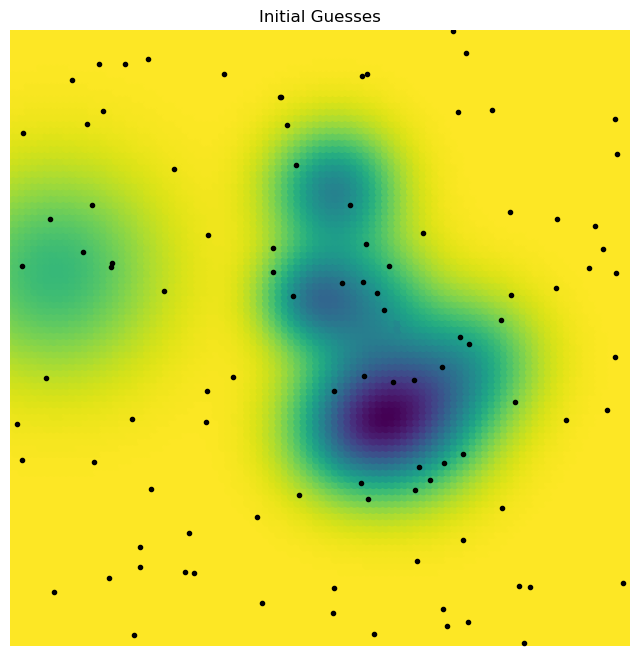

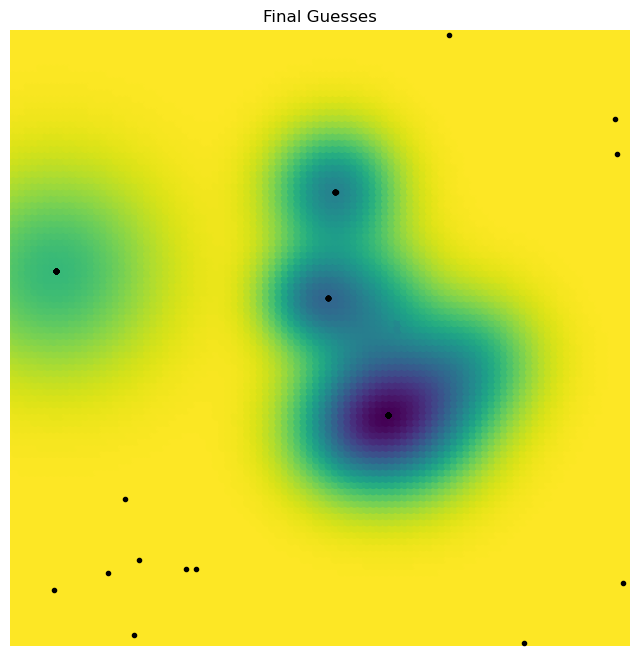

In [22]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*optimizer.X.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

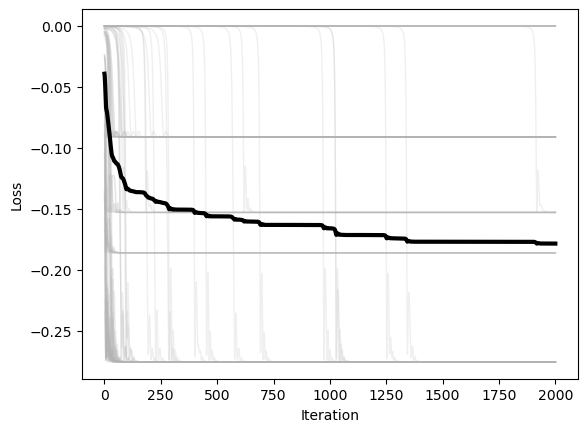

In [23]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


Text(0.5, 1.0, 'Final Guesses')

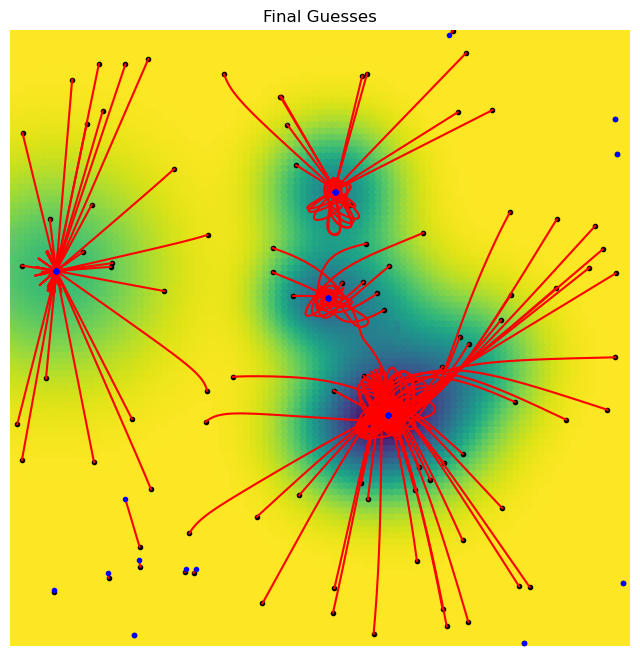

In [24]:
Xs = np.array(optimizer.Xs)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b');
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [25]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.b');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

# Stochastic Gradient Descent

We can also add stochasticity to the gradient descent update rule

$$
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x}) + \boldsymbol{\epsilon_t}
$$
where $\epsilon_t$ is a random noise term

### Dynamical interpretation:

We can add a time-dependent noise term to our overdamped dynamical system for gradient descent.
$$
\dot{\mathbf{x}} = -\frac{1}{\gamma}\nabla \mathcal{U}(\mathbf{x}) + \boldsymbol{\xi_t}
$$

Usually we assume that the noise term is a Langevin process, such as the random "kicks" encountered during the Brownian motion of a particle in a fluid. For each component of the vector $\boldsymbol{\epsilon_t}$,
$$
\langle \xi_t \xi_s \rangle = 2 \gamma \delta(t-s)
$$
$$
\langle \xi_t \rangle = 0
$$
Over discrete times steps, this corresponds the noise vector having a Gaussian distribution with zero mean. We also assume that the different dimensions of the noise force are uncorrelated (the covariance matrix is diagonal).

In [29]:
class StochasticGradientDescent(BaseOptimizer):
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, noise, **kwargs):
        super().__init__(loss, **kwargs)
        self.noise = noise

    def update(self, X):
        grad = self.loss.grad(self.X)
        noisy_grad = grad + self.noise * np.random.randn(*grad.shape)
        return X - self.lr * noisy_grad

## A Caveat

+ Our stochastic gradient descent update rule randomly samples and then nudges the gradient accordingly
+ The stochastic gradient descent rules often encountered in machine learning models randomly sample a minibatch of training data points. Effectively, the loss landscape of ML models is a noisy version of the loss landscape we have been considering so far, and it is approximated by the training data---so randomly subsampling data is equivalent to randomly sampling the true loss landscape

In [30]:
# Initialize optimizer
optimizer = StochasticGradientDescent(loss, lr=0.1, noise=0.2, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

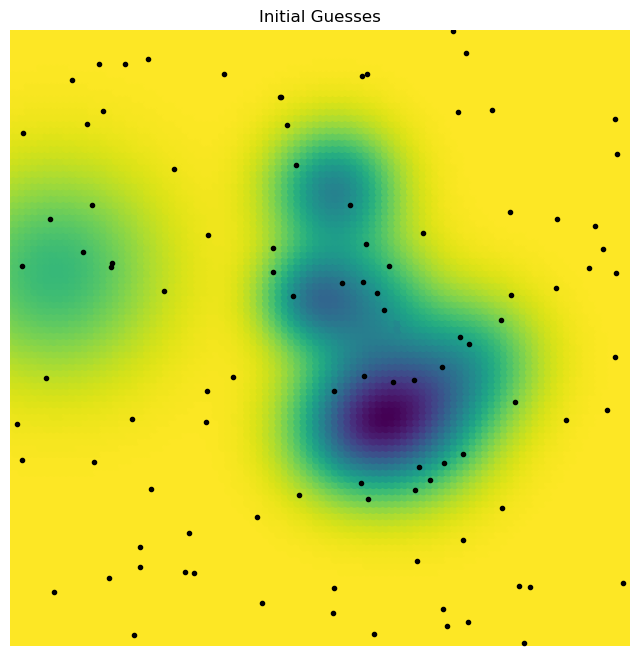

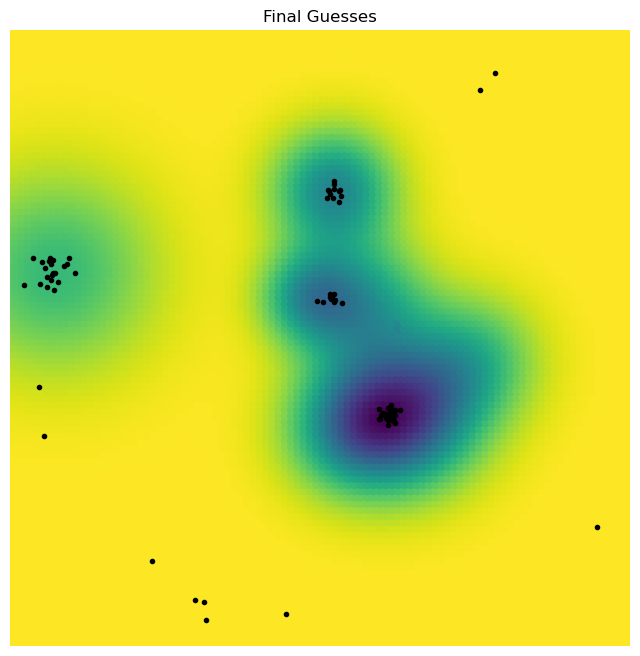

In [31]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*optimizer.X.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

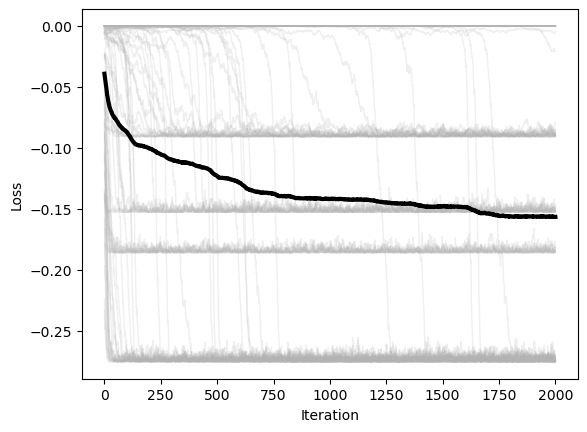

In [32]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


Text(0.5, 1.0, 'Final Guesses')

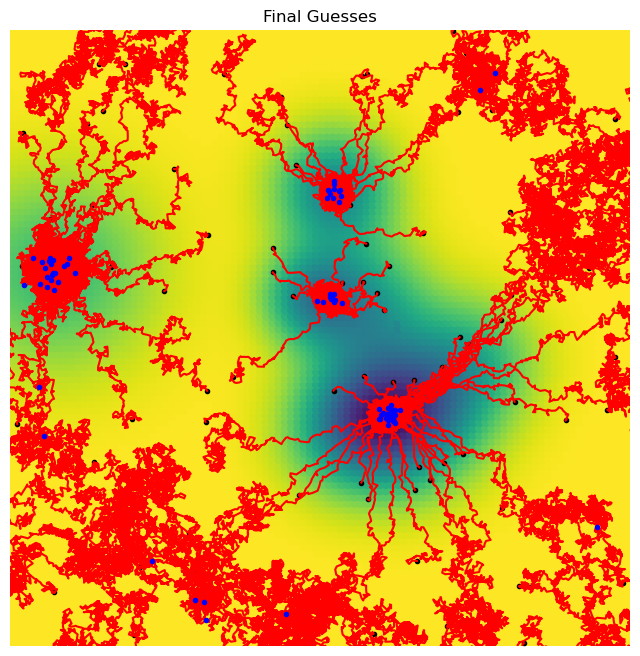

In [33]:
Xs = np.array(optimizer.Xs)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b');
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [34]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.b');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

# Constrained optimization with projected gradient descent

+ So far, the individual components of our vector $\mathbf{x}$ have been updated independently of each other. They only interact in the sense that both specify the value of the loss function $\mathcal{L}(\mathbf{x})$, at which we compute the gradient.
+ What if we want to impose constraints on the components of $\mathbf{x}$?

Example: The squared elements of $\mathbf{x}$ must sum to one. This is a common constraint when we are optimizing over unit directions in a space, or potentially when we are optimizing over probability distributions.
$$
\sum_i x_i^2 = 1
$$

If we denote the set as $\mathcal{S} = \{ \mathbf{x} \in \mathbb{R}^n : \sum_i x_i^2 = 1 \}$, then we can project a vector $\mathbf{x}$ onto the set by solving the following optimization problem:
$$
\mathbf{x}^* = \arg \min_{\mathbf{x} \in \mathcal{S}} \|\mathbf{x} - \mathbf{x}^*\|^2
$$

## Projected gradient descent

We enforce the constraint by projecting the output gradient descent update rule onto the set at each step
$$
\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla \mathcal{L}(\mathbf{x})
$$
Followed by projection,
$$
\mathbf{x} \leftarrow \text{Proj}_{\mathcal{S}}(\mathbf{x})
$$

<!-- ## Example: Constrained optimization

+ Consider the problem of minimizing the function
$$
\mathcal{L}(\mathbf{x}) = \frac{1}{2} \mathbf{x}^T \mathbf{A} \mathbf{x} + \mathbf{b}^T \mathbf{x}
$$
subject to the constraint
$$
\mathbf{c}^T \mathbf{x} = 0
$$
where $\mathbf{A}$ is a symmetric positive definite matrix, $\mathbf{b}$ is a vector, and $\mathbf{c}$ is a vector. -->



In [39]:
class ProjectedGradientDescent(BaseOptimizer):
    """A Multivariate Gradient Descent Optimizer"""

    def __init__(self, loss, **kwargs):
        super().__init__(loss, **kwargs)

    def update(self, X):
        self.X = self.project(self.X)
        grad = self.loss.grad(self.X)
        return self.project(X - self.lr * grad)

    def project(self, X):
        """
        Project onto the simplex consisting of points where the norm of all elements is one
        """
        X = X.copy()
        X /= np.linalg.norm(X, axis=1, keepdims=True)
        return X
        

In [40]:
# Initialize optimizer
optimizer = ProjectedGradientDescent(loss, lr=0.1, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3


# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

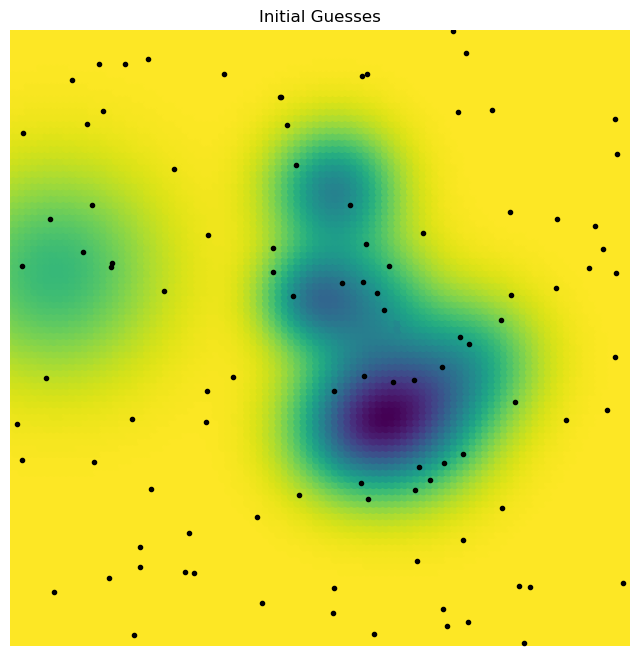

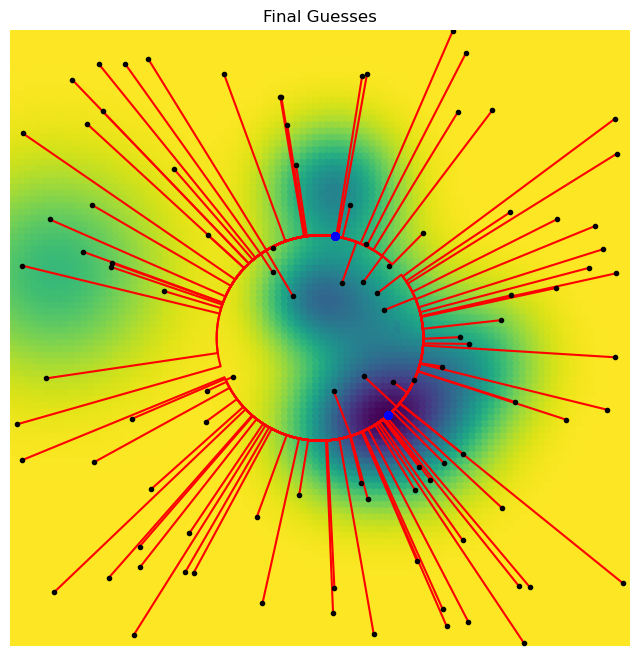

In [41]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r', zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [42]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    # plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    # plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.r');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

### What about inequality constraints? 

+ What if we don't require strictly that the individual elements $x_i$ add up to something, but instead that they are bounded?
+ For example, $\sum_i x_i^2 \leq 1$ or $0 \leq x_i \leq 1$?
+ Where we are constrained to a subdomain, but *not* a subspace. This is the setting for Interior Point methods
+ See the [textbook by Boyd and Vandenberghe](https://web.stanford.edu/~boyd/cvxbook/) for discussion of these methods

## First-order methods widely-used today

+ Stochastic gradient descent remains suprisingly effective. Remember that the stochasticity in ML comes from approximating our loss landscape from a subset of the data, not from the noise term in the update rule
+ Adam, Adagrad, RMSprop, etc. are all variants of stochastic gradient descent. We track gradients over time, and use them to adapt the learning rate and gradient in various ways. 

# Second order methods

+ So far, we have only been using methods in which we take the first derivative of the loss function. 
+ As we saw in the 1D case, we can converge much faster by using information from the second derivative of the loss function to adjust our learning rate

For a loss function $\mathcal{L}(\mathbf{x}) \in \mathbb{R}$ computed at location $\mathbf{x} \in \mathbb{R}^d$, the second derivative is given by the Hessian matrix, $\mathbf{H} = \nabla^2 \mathcal{L}(\mathbf{x}) \in \mathbb{R}^{d \times d}$

Writing this out in matrix form, we have
$$
\mathbf{H} = \begin{bmatrix}
\frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_1^2} & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_1 \partial x_d} \\
\frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_2 \partial x_1} & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_2^2} & \cdots & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_2 \partial x_d} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_d \partial x_1} & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_d \partial x_2} & \cdots & \frac{\partial^2 \mathcal{L}(\mathbf{x})}{\partial x_d^2}
\end{bmatrix}
$$

Recalling our intuition from the 1D case, we can see that the Hessian matrix is a measure of how steeply curved the loss function appears at a given point. If the Hessian is positive definite, then the loss function is locally convex, and we can use the second derivative to adjust our learning rate.

## Newton's method

+ Newton's method is a second order method for unconstrained optimization

+ The update rule is given by
$$
\mathbf{x} \leftarrow  \mathbf{x} - \mathbf{H}^{-1} \nabla \mathcal{L}(\mathbf{x}_t)
$$

<!-- + Inverting the Hessian matrix is computationally expensive, and so we can instead adapt the learning rate based purely on the eigenvalues of the Hessian matrix -->

<!-- ## Quasi-Newton methods

+ Quasi-Newton methods are a class of second order methods for unconstrained optimization
+ They are based on approximating the Hessian matrix using a low-rank approximation
+ The update rule is given by
$$
\mathbf{x} \leftarrow  \mathbf{x} - \mathbf{B}^{-1} \nabla \mathcal{L}(\mathbf{x}_t)
$$
where $\mathbf{B}$ is a low-rank approximation to the Hessian matrix -->




## The Random Gaussian well landcape

Recall that our test landscape is a sum of Gaussian wells,
$$
\mathcal{L} = \sum_{p=1}^P \mathcal{L}_p = -\sum_{p=1}^P \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right)
$$
where $\mathbf{x} \in \mathbb{R}^d$ is the location in the landscape, $\boldsymbol{\mu}_p \in \mathbb{R}^d$ is the center of the $p$th well, and $\sigma$ is the width of the well.

The gradient of the loss function is given by
$$
\nabla \mathcal{L} = \sum_{p=1}^P \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right) \frac{(\mathbf{x} - \boldsymbol{\mu}_{p})}{\sigma^2}
$$

The Hessian matrix is given by
$$
\mathbf{H} = \sum_{p=1}^P \exp\left(-\frac{(\mathbf{x} - \boldsymbol{\mu}_{p})^2}{2\sigma^2}\right) \left(\frac{1}{\sigma^2} \mathbf{I} - \frac{(\mathbf{x} - \boldsymbol{\mu}_{p})(\mathbf{x} - \boldsymbol{\mu}_{p})^T}{\sigma^4}\right)
$$
Note the order of the last product, which is an outer product and not a contracting inner product.

In [43]:
class RandomLossLandscapeWithHessian(RandomLossLandscape):
    """
    Subclass of the Random Gaussian Loss Landscape that adds an analytic Hessian calculation
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Everything is passed to the RandomLossLandscape constructor

    def _hessian_gaussian_well(self, X, width=1):
        oprod = np.einsum('ijk,imk->ijmk', X, X) # (n, d, d, 1)
        iden = np.eye(X.shape[1])[None, ..., None] 
        return (-iden + oprod / width**2) / width**2 * self._gaussian_well(X, width)[:, None, None, :]

    def hessian(self, X): 
        return np.einsum('...i,i->...', self._hessian_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), self.coeffs)

loss = RandomLossLandscapeWithHessian(random_state=0, n_wells=8)

(-3.3, 3.3, -3.3, 3.3)

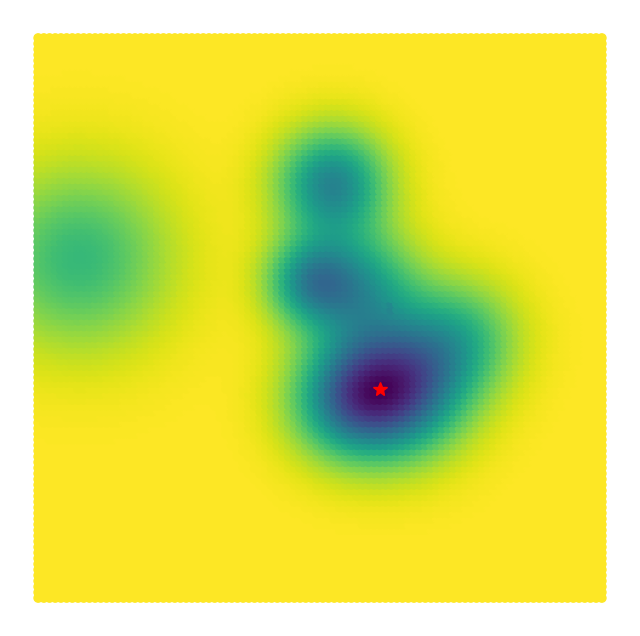

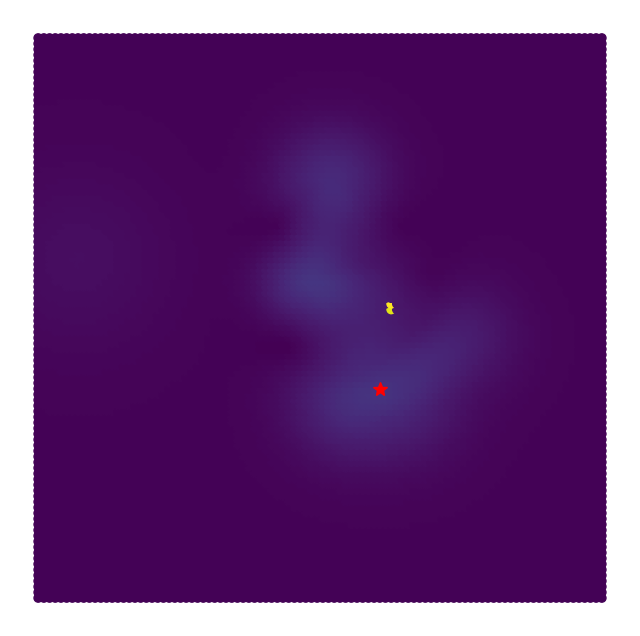

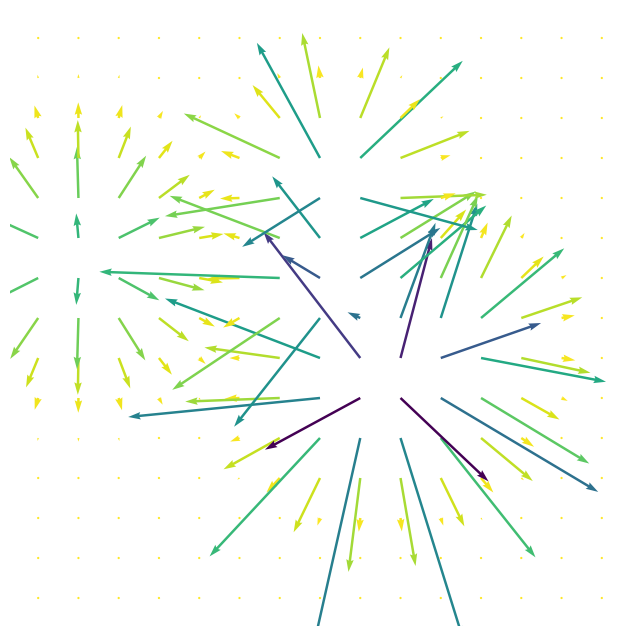

In [44]:

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss(X) # same as loss.loss(X) because class is callable

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*r', markersize=10)
plt.axis('off')

plt.figure(figsize=(8, 8))
eig_dirs = np.linalg.eigvalsh(loss.hessian(X))
signed_log = lambda x: np.sign(x) * np.log(1 + np.abs(x))
plt.scatter(X[:, 0], X[:, 1], c=signed_log(np.max(eig_dirs, axis=1)))
plt.plot(xx.ravel()[Z.argmin()], yy.ravel()[Z.argmin()], '*r', markersize=10)
plt.axis('off')

plt.figure(figsize=(8, 8))
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)
plt.quiver(X[:, 0], X[:, 1], loss.grad(X)[:, 0], loss.grad(X)[:, 1], Z, scale=1e0)
# plt.streamplot(x, y, loss.grad(X)[:, 0].reshape(100, 100), loss.grad(X)[:, 1].reshape(100, 100), color=Z.reshape(100, 100))
plt.axis('off')

In [93]:
class MultivariateNewtonsMethod:
    """
    Optimize a function, subject to the constraint that the solution lies in a convex set.
    """
    
    def __init__(self, loss, max_iter=1000, tol=1e-6, random_state=None, store_history=False):
        self.loss = loss
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def fit(self, X):
        
        self.X = X
        if self.store_history:
            self.Xs = [self.X.copy()]
            self.losses = [self.loss(X)]
        for i in range(self.max_iter):


            grad = self.loss.grad(self.X)
            hess = self.loss.hessian(self.X) + 1e-12 * np.eye(self.X.shape[1])[None, ...]
            ## last term helps with numerical stability
            ihess = np.linalg.inv(hess)

            self.X -= np.einsum('ink,ik->in', ihess, grad, optimize=True)

            ## momentum
            # self.X -= 0.01 * np.einsum('ink,ik->in', ihess, grad, optimize=True)


            if self.store_history:
                self.Xs.append(self.X.copy())
                self.losses.append(self.loss(self.X))

            # Stop early if loss is not decreasing any more for *any* batch elements
            if np.linalg.norm(self.loss.grad(self.X)) < self.tol:
                break

In [94]:
# Initialize optimizer
optimizer = MultivariateNewtonsMethod(loss, max_iter=1000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3
# X0 = np.random.random(size=(100, 2))

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

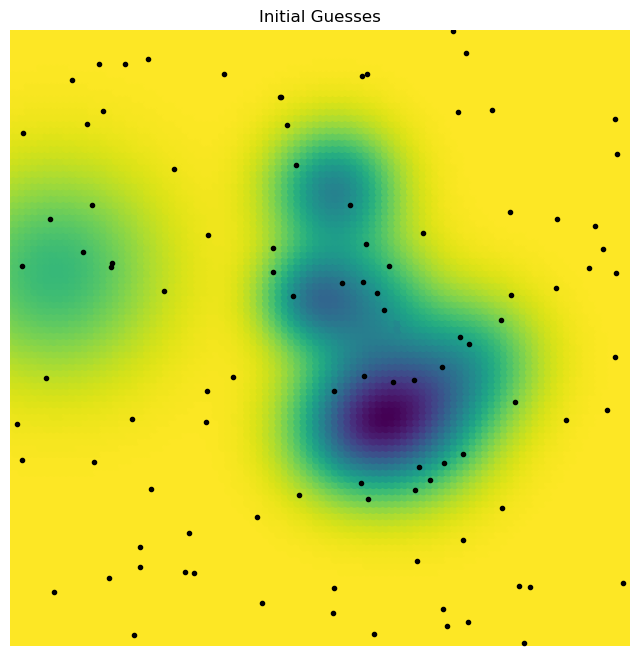

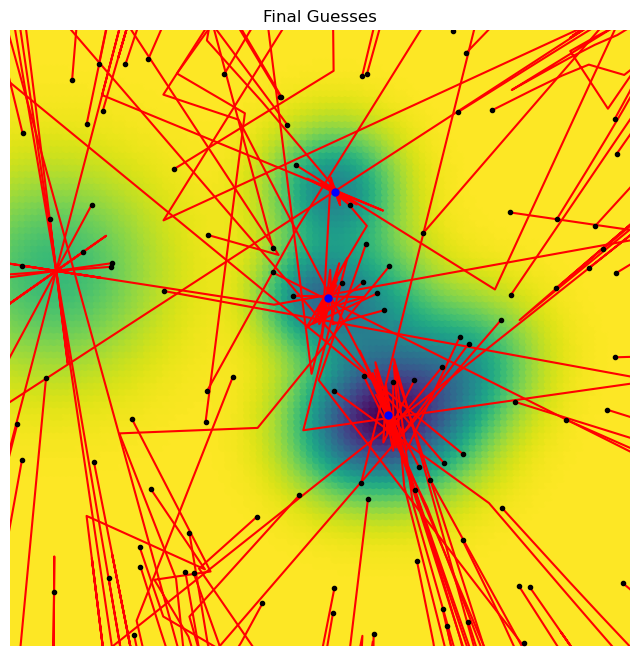

In [95]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r', zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

Text(0, 0.5, 'Loss')

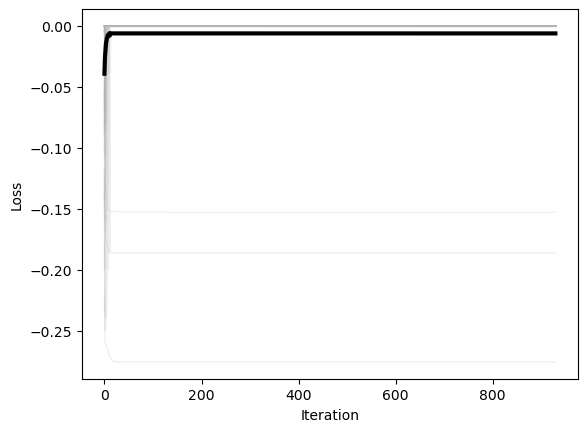

In [96]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [97]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    # plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    # plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.r');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=929), Output()), _…

<function __main__.plotter(i)>

## The results are underwhelming

+ This acts weird because our objective function is non-convex, so convergence is not guaranteed. Notice that points close to the biggest well had no problem; it's the points in between wells that are having trouble. That's because these are regions with negative curvature.

+ The Hessian matrix is not positive definite in some regions, so we can't use Newton's method. We can use quasi-Newton methods, but they are not guaranteed to converge to the global minimum.

+ We can try adding momentum to the update rule

## The spectrum of the Hessian


+ The eigenvalues of the Hessian matrix are a measure of how steeply the loss function changes in each direction
+ For a harmonic potential, they give us the stiffness of the potential in each direction

Taylor expand the potential around a given point $\mathbf{x}$, relative to a nearby point $\mathbf{x}'$
$$
\mathcal{L}(\mathbf{x}) \approx \mathcal{L}(\mathbf{x'}) + \nabla \mathcal{L}(\mathbf{x'})^T (\mathbf{x} - \mathbf{x'}) + \frac{1}{2} (\mathbf{x} - \mathbf{x'})^T \mathbf{H}(\mathbf{x'}) (\mathbf{x} - \mathbf{x'}) + ...
$$
where $\mathbf{v} \in \mathbb{R}^d$ is a small displacement from the current point $\mathbf{x}$.

+ Imagine that $\mathbf{x} - \mathbf{x'}$ is a small displacement along one of the eigenvector axes of a multivariate harmonic potential. The relative size of the second term is directly proportional to the eigenvalue associated with that direction

+ But different directions have different eigenvalues, so the relative size of the second term depends on the direction of the displacement.

+ For very oblong potentials, the difference along various directions can be dramatic. This can be quantified by condition number, or the the ratio of the largest to smallest eigenvalue: $$ {\displaystyle \kappa (H)={\frac {\left|\lambda _{\text{max}}(H)\right|}{\left|\lambda _{\text{min}}(H)\right|}},} $$

+ Optimally, we'd have a separate learning rate for each direction in space, but this becomes computationally expensive in high dimensions. Instead, we can use the condition number to adapt the learning rate.

Adjust learning rate based on condition number

$$
\mathbf{x} \leftarrow \mathbf{x} - \frac{\eta}{\kappa(\mathbf{H}) + \epsilon} \nabla \mathcal{L}(\mathbf{x})
$$
where $\eta$ is the initial learning rate, $\kappa(\mathbf{H})$ is the condition number of the Hessian matrix, and $\epsilon$ is a small constant to prevent division by zero.


Another option is to adjust learning rate based only the largest Hessian eigenvalue (can use the power method to find this quickly)
$$
\mathbf{x} \leftarrow \mathbf{x} - \frac{\eta}{\lambda_{\text{max}}} \nabla \mathcal{L}(\mathbf{x})
$$
where $\lambda_{\text{max}}$ is the largest eigenvalue of the Hessian matrix


Another option is to scale using the smallest eigenvalue as well
Another option is to adjust learning rate based only the largest Hessian eigenvalue (can use the power method to find this quickly)
$$
\mathbf{x} \leftarrow \mathbf{x} - \frac{\eta}{|\lambda_{\text{max}|} + |\lambda_{\text{min}}|} \nabla \mathcal{L}(\mathbf{x})
$$
where $\lambda_{\text{max}}$ is the largest eigenvalue of the Hessian matrix

In [62]:
class GradientDescentAdaptive(BaseOptimizer):
    """
    Optimize a function, subject to the constraint that the solution lies in a convex set.
    """
    
    def __init__(self, loss, **kwargs):
        super().__init__(loss, **kwargs)

    def update(self, X):
        grad = self.loss.grad(self.X)
        hess = self.loss.hessian(self.X) + 1e-12 * np.eye(self.X.shape[1])[None, ...]
        scale = np.abs(np.linalg.eigh(hess)[0][-1]) # + np.abs(np.linalg.eigh(hess)[0][0])
        return X - self.lr * grad / scale

In [63]:
# Initialize optimizer
optimizer = GradientDescentAdaptive(loss, max_iter=2000, tol=1e-6, random_state=0, store_history=True)

# Initialize starting point
X0 = 6 * np.random.random(size=(100, 2)) - 3

# Fit optimizer
optimizer.fit(X0.copy())

Text(0.5, 1.0, 'Final Guesses')

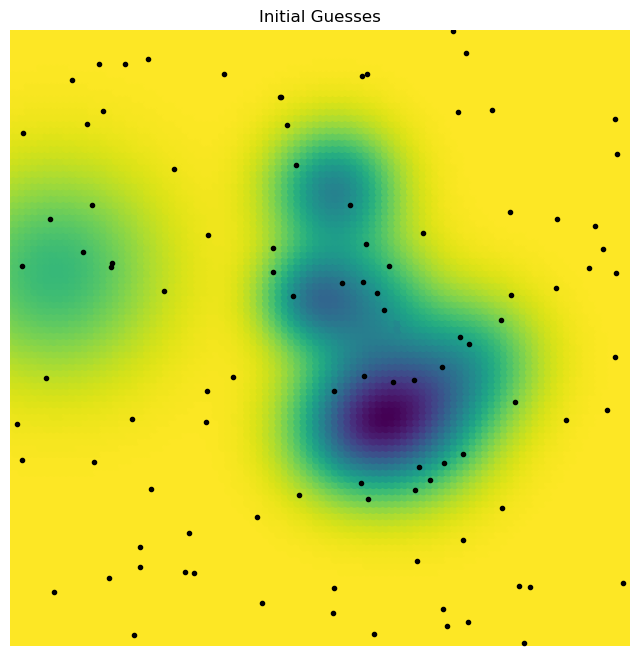

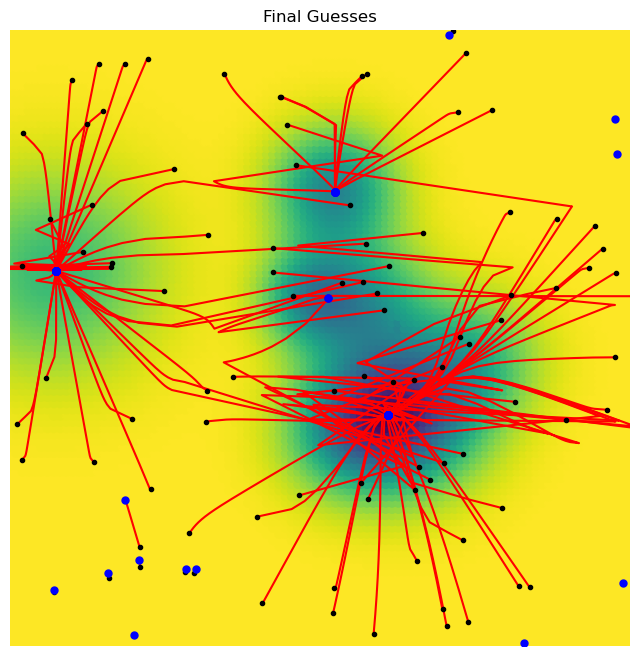

In [64]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.k')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.figure(figsize=(8, 8))
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z, zorder=-2)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], 'r', zorder=-1);
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', markersize=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Final Guesses')

In [65]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

Xs = np.array(optimizer.Xs)

def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Z)
    # plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.k');
    # plt.plot(Xs[:i, :, 0], Xs[:i, :, 1], 'r');
    plt.plot(Xs[i, :, 0], Xs[i, :, 1], '.r');
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, Xs.shape[0] - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=2000), Output()), …

<function __main__.plotter(i)>

## Quasi-Newton methods

+ Computing the Hessian matrix is computationally expensive in high dimensions, even moreso its inverse
+ Recall that solving a linear system took $\mathcal{O}(N^3)$ operations
+ We can instead approximate the Hessian matrix using a low-rank approximation

Most popular: L-BFGS: use an iterative method to approximate the Hessian matrix at each step
+ We now have an interior loop within our optimization, so we hope that the inner approximation loop converges quickly and terminates after a few steps


# What to do without any derivative functions?

## What about calculations with intermediate variables?

+ Our loss function required a sum over Gaussian wells, and so we had elaborate matrix-vector products to compute the gradient and Hessian

## Finite difference derivatives

+ Symbolic derivatives much more practical
+ Computing them by hand is usually possible, but tedious
+ Unfavorable scaling in high dimensions

## Any tricks to do it faster?

+ Computational tricks for fast multivariate chain rule: Backpropagation, automatic differentiation
+ + Instead of writing down the full input-output and its inverse, we can just write down the matrix-vector products in a computation graph, and then invert it to apply the chain rule.
+ Exact like symbolic derivatives, but not explicit---we just store the order of the chain rule
+ Most complex functions are compositions of matrix-vector products and unary functions like $\sin$, $\tanh$, etc
+ + Basic idea: the multivariate chain rule can be written as a graph, traversing this graph can be optimized to reduce calls to nodes by caching intermediate results on the forward pass, etc
+ + We'll look at tools implementing these ideas behind the scenes soon, but we won't go over the mathematics until the deep learning section of the course.
